##**EJERCICIO PRACTICO  - SERVICIO TERAPIA OCUPACIONAL**
###Jaime Guzmán Pantoja

#Configuaciones Iniciales

In [ ]:
# Importar Librerias generales
!pip install unidecode
import pandas as pd
import io
from google.colab import files
import numpy as np
import time
import matplotlib.pyplot as plt
import geopandas as gpd
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Instalación de dependencias necesarias
!pip install unidecode
!pip install geopandas

import pandas as pd
import sys

sys.path.append('/content/drive/My Drive/Base de Datos_TFM/PROYECTO_FINAL_TFM')

from excel_to_csv_converter import ExcelToCsvConverter

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from unidecode import unidecode

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [ ]:

from excel_to_csv_converter import ExcelToCsvConverter

# Ruta base donde se encuentran archivos xlsx
ruta_base = '/content/drive/My Drive/Base de Datos_TFM/PROYECTO_FINAL_TFM/'

# Base de datos: IDIPRON.xlsx
converter = ExcelToCsvConverter(ruta_base + 'Data_Terapia_Ocupacional.xlsx', 'Data_Terapia_Ocupacional.csv', 'BASE', '|')
converter.convert_to_csv()


Conversion complete. Excel file /content/drive/My Drive/Base de Datos_TFM/PROYECTO_FINAL_TFM/Data_Terapia_Ocupacional.xlsx converted to CSV file Data_Terapia_Ocupacional.csv with | as delimiter.


In [ ]:
idipron = pd.read_csv('Data_Terapia_Ocupacional.csv', encoding='utf-8', sep='|')


In [ ]:
idipron.shape

(5000, 9)

In [ ]:
## Data faltante en df de idipron
idipron.isnull().sum()
porcentaje_nulos = (idipron.isnull().mean() * 100).round(2)
porcentaje_nulos

PLAN_DE_INTERVENCION_B    0.0
EDAD_ACTUAL               0.0
NUTRICION_B               0.0
ODONTOLOGIA_B             0.0
ATENCION_ENFERMERIA_B     0.0
VALORACIONES_B            0.0
INTERVENCIONES_B          0.0
ESTRATO                   0.0
TERAPIA_OCUPACIONAL_B     0.0
dtype: float64

# Análisis predictivo

### SERVICIO TERAPIA OCUPACIONAL

### Preparación del modelo

In [ ]:
# Definir las características (X) y la variable objetivo (y)
X_ter = idipron.drop(columns=["TERAPIA_OCUPACIONAL_B"])
y_ter = idipron["TERAPIA_OCUPACIONAL_B"]

### Modelo 1 KNN - Terapia Ocupacional

Max Value uniform : 0.775250882069263 (97)
Max Value distance : 0.6937247202454998 (96)


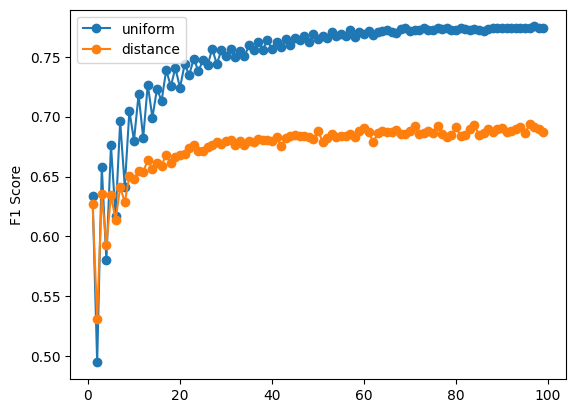

In [ ]:
cv = KFold(n_splits = 10, shuffle = True)

for i, weights in enumerate(['uniform', 'distance']):
    total_scores = []
    for n_neighbors in range(1, 100):
        fold_f1_scores = []  # Changed variable name to reflect F1 scores
        knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        # Iterate through cross-validation splits
        for train_fold, test_fold in cv.split(idipron):
            # Split data
            f_train = idipron.loc[train_fold]
            f_test = idipron.loc[test_fold]
            # Train and predict
            knn.fit(X=f_train.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y=f_train['TERAPIA_OCUPACIONAL_B'])
            y_pred = knn.predict(X=f_test.drop(['TERAPIA_OCUPACIONAL_B'], axis=1))
            # Evaluate using F1 score
            f1 = f1_score(f_test['TERAPIA_OCUPACIONAL_B'], y_pred.round())
            fold_f1_scores.append(f1)
        total_scores.append(sum(fold_f1_scores) / len(fold_f1_scores))

    plt.plot(range(1, len(total_scores) + 1), total_scores, marker='o', label=weights)
    print('Max Value ' + weights + " : " + str(max(total_scores)) + " (" + str(np.argmax(total_scores) + 1) + ")")
    plt.ylabel('F1 Score')


plt.legend()
plt.show()

In [ ]:
# Resultado de la parametrización y elección de K's y peso
n_neighbors = 97
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)
# fit, estimación y resultado

knn.fit( X = idipron.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y = idipron['TERAPIA_OCUPACIONAL_B'])
y_pred_ter_knn = knn.predict(X = idipron.drop(['TERAPIA_OCUPACIONAL_B'], axis = 1))
f1 = f1_score(idipron['TERAPIA_OCUPACIONAL_B'], y_pred_ter_knn.round())
print ('F1', f1)

F1 0.7754148740012293


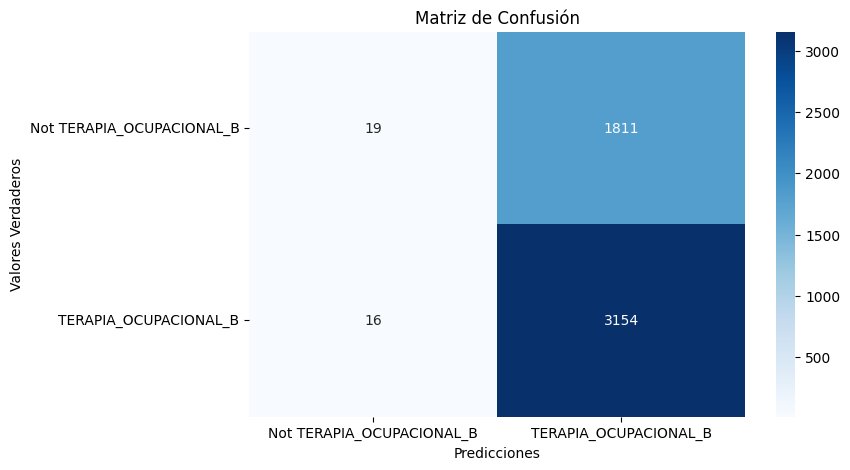

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(idipron['TERAPIA_OCUPACIONAL_B'], y_pred_ter_knn.round())

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'], yticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 2 Random Forest - Terapia Ocupacional

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Cambiando el modelo a clasificador
classifier = RandomForestClassifier()

def report(results, n_top=3):  # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Parameters: {0}".format(results['params'][candidate]))
            # Agregando la impresión del F1 score
            print("Mean F1 score: {0:.5f}".format(results['mean_test_score'][candidate]))
            print("")

# Hiperparametrización
param_dist = {
    "n_estimators": [32, 64, 128],  # Number of trees in random forest
    "max_features": ['log2', 'sqrt'],  # Number of features to consider at every split
    "max_depth": [24, 16, 8],  # Maximum number of levels in tree
    "min_samples_split": [2, 4, 6],  # Minimum number of samples required to split a node
    "min_samples_leaf": [8, 12, 16],  # Minimum number of samples required at each leaf node
    "bootstrap": [True, False]  # Method of selecting samples for training each tree
}

# Configurar GridSearchCV para usar el F1 score como métrica
f1_scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_dist, cv=5, scoring=f1_scorer, n_jobs=-1)

grid_search.fit(X=idipron.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y=idipron['TERAPIA_OCUPACIONAL_B'])

# Mostrar mejores resultados
report(grid_search.cv_results_)

Model with rank: 1
Parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 64}
Mean F1 score: 0.77605

Model with rank: 2
Parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 6, 'n_estimators': 128}
Mean F1 score: 0.77598

Model with rank: 3
Parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 2, 'n_estimators': 64}
Mean F1 score: 0.77580



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

# Hiperparámetros elegidos
classifier = RandomForestClassifier(n_estimators=64, max_depth=8, max_features='sqrt', min_samples_leaf=12, min_samples_split=6)

# Entrenamiento
classifier.fit(X=idipron.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y=idipron['TERAPIA_OCUPACIONAL_B'])

# Predicción
y_pred_ter_rf = classifier.predict(X=idipron.drop(['TERAPIA_OCUPACIONAL_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(idipron['TERAPIA_OCUPACIONAL_B'], y_pred_ter_rf, pos_label=1)

print("F1 Score:", f1)

F1 Score: 0.7766728054020872


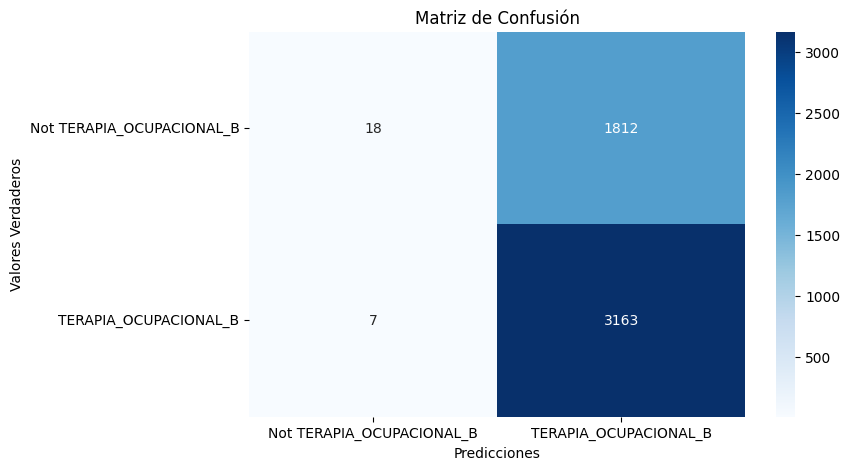

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_ter_rf = y_pred_ter_rf.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(idipron['TERAPIA_OCUPACIONAL_B'], y_pred_ter_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'], yticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 3 AdaBoost - Terapia Ocupacional

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Definición de hiperparámetros
param_dist = {
    "n_estimators": [8, 16, 32, 64, 128],
    "learning_rate": [0.01, 0.05, 0.1],
    # 'loss' no es un parámetro en AdaBoostClassifier, por lo que se omite
}

# Creación del modelo AdaBoost con un DecisionTreeClassifier como base
grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy')),
                        param_grid=param_dist, cv=5, scoring='f1')

# Entrenamiento del modelo con el conjunto de entrenamiento
grid_ada.fit(X=idipron.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y=idipron['TERAPIA_OCUPACIONAL_B'])

# Mejor modelo encontrado
best_ada = grid_ada.best_estimator_
print(best_ada)



AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.1, n_estimators=128)


In [ ]:
# Entrenamiento y predicción con el mejor modelo
best_ada.fit(X=idipron.drop(['TERAPIA_OCUPACIONAL_B'], axis=1), y=idipron['TERAPIA_OCUPACIONAL_B'])
y_pred_ter_ada = best_ada.predict(X=idipron.drop(['TERAPIA_OCUPACIONAL_B'], axis=1))

# Cálculo del F1 score
f1 = f1_score(idipron['TERAPIA_OCUPACIONAL_B'], y_pred_ter_ada,pos_label=1)
print('F1 Score:', f1)


F1 Score: 0.8807419214606579


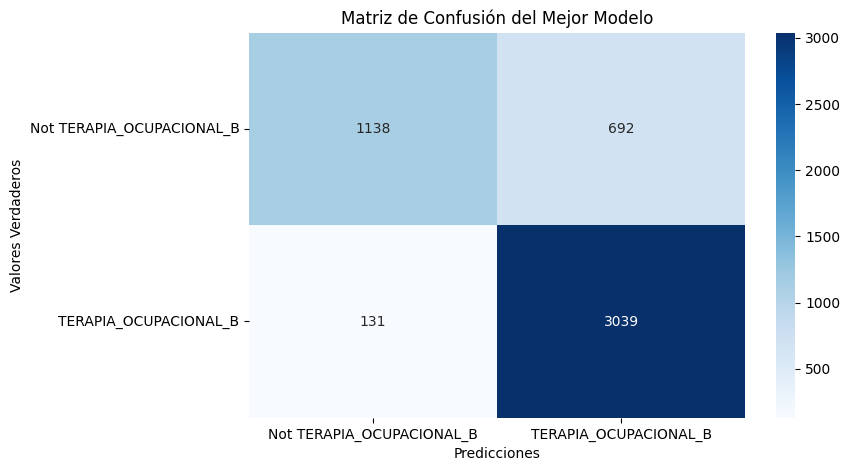

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_ter_ada = y_pred_ter_ada.round()

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(idipron['TERAPIA_OCUPACIONAL_B'], y_pred_ter_ada)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'], yticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'])
plt.title('Matriz de Confusión del Mejor Modelo')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

###Modelo 4 Regresion Logistica - Terapia Ocupacional

In [ ]:
  # Conjunto de datos de entrenamiento
  X_train_ter = idipron.drop("TERAPIA_OCUPACIONAL_B", axis=1)
  y_train_ter = idipron["TERAPIA_OCUPACIONAL_B"].copy()

  # Conjunto de datos de pruebas
  X_test_ter = idipron.drop("TERAPIA_OCUPACIONAL_B", axis=1)
  y_test_ter = idipron["TERAPIA_OCUPACIONAL_B"].copy()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamos un algoritmo basado en regresión logística
clf = LogisticRegression(solver="newton-cg", max_iter=1000)
clf.fit(X_train_ter, y_train_ter)

# Realizamos predicciones con el conjunto de prueba
y_pred_ter_rl = clf.predict(X_test_ter)

In [ ]:
from sklearn.metrics import f1_score
print("F1 score:", f1_score(y_test_ter, y_pred_ter_rl, pos_label=1))

F1 score: 0.7760097919216646


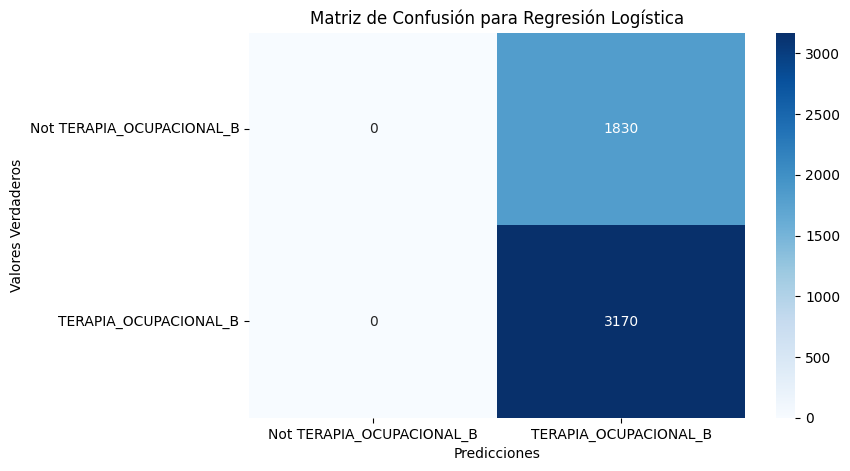

In [ ]:
# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_ter, y_pred_ter_rl)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'], yticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'])
plt.title('Matriz de Confusión para Regresión Logística')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

Curvas ROC Y PR

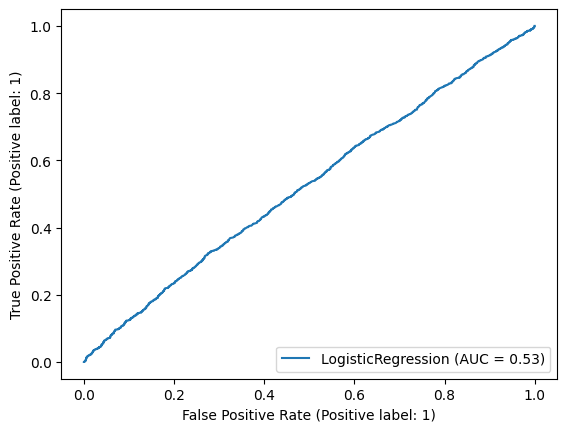

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test_ter, y_test_ter)

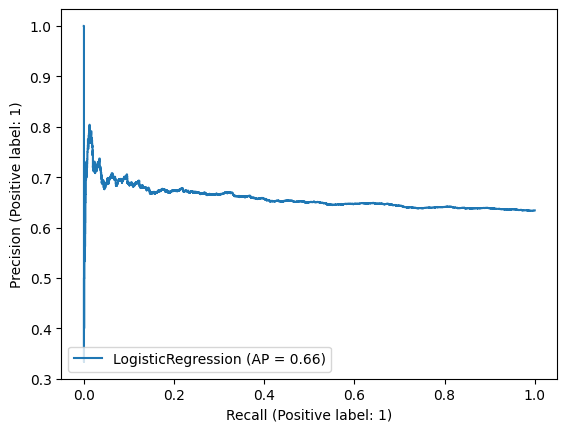

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_test_ter, y_test_ter)

###Modelo 5 Arbol de decisión - Terapia Ocupacional





In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Configuración de los hiperparámetros a probar
param_grid = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Inicialización del clasificador de árbol de decisión
clf_tree = DecisionTreeClassifier(random_state=42)

# Creación del objeto GridSearchCV
grid_search = GridSearchCV(estimator=clf_tree, param_grid=param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5)

# Ajuste de GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train_ter, y_train_ter)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Mejor modelo encontrado por GridSearchCV
best_tree = grid_search.best_estimator_

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Predicción con el conjunto de entrenamiento usando el mejor modelo
y_pred_ter_dt = best_tree.predict(X_test_ter)

# Cálculo del F1 Score para el conjunto de entrenamiento
print("F1 Score Test Set:", f1_score(y_test_ter, y_pred_ter_dt, pos_label=1))

F1 Score Test Set: 0.7916839916839917


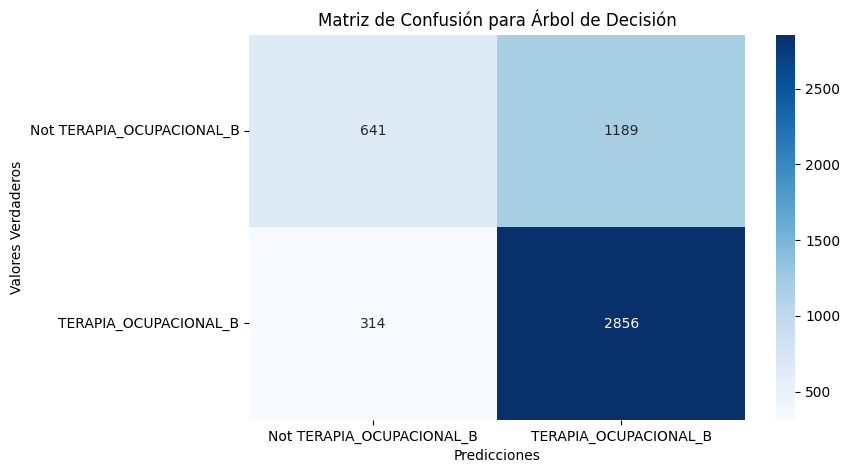

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicción con el conjunto de prueba
y_pred_ter_rf = best_tree.predict(X_test_ter)

# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test_ter, y_pred_ter_rf)

# Visualización de la matriz de confusión usando heatmap de seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'], yticklabels=['Not TERAPIA_OCUPACIONAL_B', 'TERAPIA_OCUPACIONAL_B'])
plt.title('Matriz de Confusión para Árbol de Decisión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()
